# Machine Learning Tutorial
- GDSO pre-workshop, July 2019
- Instructor: [Everett Wetchler](https://github.com/wetchler)

## Predicting country-level happiness from development indicators

Datasets:
1. Country-level happiness data
  * Reusing from [Wednesday's tutorial](https://github.com/wetchler/pandas), which comes from Gallup via _Our World in Data_ [here](https://ourworldindata.org/happiness-and-life-satisfaction)
  * `data/happiness.csv`
1. Development indicators for each country (gdp, mortality, education, etc), measured roughly around 2014
  * From [this Kaggle dataset](https://www.kaggle.com/joniarroba/65-world-indexes-gathered)
  * `data/world_indicators.csv`
  * NOTE: in a serious research project we wouldn't use the data from Kaggle, we'd get to the original sources' publications.

To keep this tutorial focused, I've pre-cleaned and merged these for you
  * **The final file is `data/merged.csv`**
  * See `data_cleaning.ipynb` for the code that produced this. A good second practice exercise in pandas!

## 0. Import all your stuff

In [1]:
%matplotlib inline

In [2]:
# Import the usual suspects in the usual way
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## 1. Load your data

In [3]:
df = pd.read_csv('data/merged.csv', index_col='country')
print(df.shape)
df.head()

(155, 7)


,happiness,mortality_under5_per_1k,log_gdp_per_capita,gini_percent,education_expected,taxes_percent_gdp,co2_per_capita
country,,,,,,,
Afghanistan,3.898032,97.3,3.275026,27.820000,9.27439,7.471639,0.420933
Albania,5.092158,14.9,4.017257,28.960000,11.82000,19.630699,1.607038
Algeria,5.685064,25.2,4.110352,38.816667,13.96534,37.361849,3.224202
Angola,4.420299,167.4,3.874367,42.660000,11.39000,18.836676,1.472216
Argentina,6.440702,13.3,4.361389,43.570000,17.94733,14.483361,4.665869


### About these columns
These are renamed slightly from their original form (see `data_cleaning.ipynb`), but in brief:
- `happiness`: average life staisfaction score in the country, from the Cantril Ladder question (0-10 scale)
- `mortality_under5_per_1k`: For every 1000 children born in the country, how many die before age 5?
- `log_gdp_per_capita`: What it sounds like. Remember from Wednesday that the log of GDP-per-capita (think of it as "number of digits in the GDP per capita") was more correlated with happiness than raw GDP per capita.
- `gini_percent`: This is a measure of wealth inequality. A value of 0 is the *most equal* with every citizen having the exact same wealth. A value of 1 is the *most unequal* with one person having all the wealth and everyone else having nothing.
- `education_expected`: If a child is born today, how many years of education do we expect them to complete in their lifetime?
- `taxes_percent_gdp`: Higher numbers = higher taxes in the country. If you take all the money the government collects in taxes, and divide it by the total GDP, you get this value.
- `co2_per_capita`: Annual CO2 emissions, per person, per year. In tons.

### Let's sneak a peak at the correlations among these
Normally we'd do this in an "exploratory data analysis" step (between cleaning and modelling), but we'll look here to build some intuition on what is (and isn't) going on.

In [4]:
# Fast way to generate a correlation matrix
df.corr()

# Interesting... what do you see?

,happiness,mortality_under5_per_1k,log_gdp_per_capita,gini_percent,education_expected,taxes_percent_gdp,co2_per_capita
happiness,1.000000,-0.669621,0.824887,-0.266532,0.729968,0.082620,0.530313
mortality_under5_per_1k,-0.669621,1.000000,-0.776690,0.344661,-0.782372,-0.069006,-0.441034
log_gdp_per_capita,0.824887,-0.776690,1.000000,-0.384897,0.825605,0.052684,0.674006
gini_percent,-0.266532,0.344661,-0.384897,1.000000,-0.326557,0.157847,-0.378260
education_expected,0.729968,-0.782372,0.825605,-0.326557,1.000000,0.167329,0.459606
taxes_percent_gdp,0.082620,-0.069006,0.052684,0.157847,0.167329,1.000000,-0.049659
co2_per_capita,0.530313,-0.441034,0.674006,-0.378260,0.459606,-0.049659,1.000000


### Some terminology
* `happiness` is our **target variable** -- the one we want to predict
* The others are our **features**, or **predictor variables**, that we use to predict the target
* `sklearn` is our main machine learning library, short for [sci-kit learn](https://scikit-learn.org/stable/documentation.html)

## 2. Make design matrices
* Make our "feature matrix" (everything but the target variable), traditionally named capital `X`
* Make our target column (just the target variable for each row), traditionally named `y`

In [5]:
# Make our "feature matrix" (everything but the target variable)
X = df.drop(columns='happiness')
# Make our target column (just the target variable for each row)
y = df['happiness']

## 3. 'Fit' the model

The library under the hood does all the hard work

In [6]:
# Normally we'd import this at the top with the others,
# but for education's sake I'm importing things closer
# to the code that uses them.

from sklearn.linear_model import LinearRegression

In [7]:
model = LinearRegression()  # Create a blank class instance
model.fit(X, y)  # fit!

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### That's it. Wait, really?
Yep. Not so bad eh?

## 4. Inspect model
This is optional as not all machine learning models are easy to interpret (e.g. neural networks). However, linear regression models are pretty intuitive, so let's look inside.

In [8]:
model.coef_  # Short for "coefficients"

# Hmmm the output below is hard to read. In theory it's the coefficients
# for each feature, in the order we listed those features.

array([-8.91219234e-04,  1.48386987e+00,  7.46772127e-03,  5.14252950e-02,
        1.57397769e-03, -5.82453516e-04])

In [9]:
# What were our features anyway?
X.columns

Index(['mortality_under5_per_1k', 'log_gdp_per_capita', 'gini_percent',
       'education_expected', 'taxes_percent_gdp', 'co2_per_capita'],
      dtype='object')

In [10]:
# Q: How do we display these together so we don't have to strain our eyes?
# A: use 'zip'
for col, coef in zip(X.columns, model.coef_):
    print(col, coef)

# Still not perfect but better?

mortality_under5_per_1k -0.000891219233880361
log_gdp_per_capita 1.4838698721252253
gini_percent 0.007467721270371652
education_expected 0.05142529499623416
taxes_percent_gdp 0.001573977694422496
co2_per_capita -0.0005824535159923983


In [11]:
# Even better pro-tip: make a quick dataframe, using it for its
# pretty-display purposes!

# Pandas is smart and understands that you gave it a bunch of rows for a dataframe.
pd.DataFrame(zip(X.columns, model.coef_),
             columns=['feature', 'coefficient'])

,feature,coefficient
0,mortality_under5_per_1k,-0.000891
1,log_gdp_per_capita,1.483870
2,gini_percent,0.007468
3,education_expected,0.051425
4,taxes_percent_gdp,0.001574
5,co2_per_capita,-0.000582


In [12]:
# A linear regression model also has an intercept, stored here:
model.intercept_

-1.4698730926981964

### OK OK, so what does this _mean_?
If you're not as familiar with linear regression, here's how you'd interpret the values above. I'm gonna generate this programmatically in case I ever change this code...

In [13]:
def summarize_linear_model(model, target_name, feature_names):
    # We'll round to 3 decimal places in printing here,
    # so it's not overwhelming to read.
    print(f"{target_name} =")
    print(f"  {model.intercept_:.3f}")
    for feature, coef in zip(feature_names, model.coef_):
          print(f"  {'+' if coef > 0 else ''}{coef:.3f} * {feature}")

In [14]:
summarize_linear_model(model, 'happiness', X.columns)

happiness =
  -1.470
  -0.001 * mortality_under5_per_1k
  +1.484 * log_gdp_per_capita
  +0.007 * gini_percent
  +0.051 * education_expected
  +0.002 * taxes_percent_gdp
  -0.001 * co2_per_capita


### That's our "model" for national happiness!

Q: What happened? Why do some highly-correlated things have tiny coefficients?

Let's join this table with the raw correlations we saw earlier

In [15]:
pd.DataFrame(zip(X.columns, model.coef_, df.corr()['happiness'].iloc[1:]),
             columns=['feature', 'coefficient', 'raw correlation w/ happiness'])

,feature,coefficient,raw correlation w/ happiness
0,mortality_under5_per_1k,-0.000891,-0.669621
1,log_gdp_per_capita,1.483870,0.824887
2,gini_percent,0.007468,-0.266532
3,education_expected,0.051425,0.729968
4,taxes_percent_gdp,0.001574,0.082620
5,co2_per_capita,-0.000582,0.530313


### So what's going on?
1. **Already explained by other variables** -- I would guess that GDP explains a lot of the information that you find in the gini coefficient, under 5 mortality, and co2 emissions -- they are all general progress indicators. It's amazing how much log-gdp-per-capita explains by itself!
2. **Features are not on the same scale.** If two features are equally useful, but one ranges from 1 to 100, and another from 1 to 10, the former will have a smaller coefficient. It's beyond our scope to get into this here, but to deal with this, generally you either scale your features to all be (say) normally distributed around 0 with variance 1, or...
3. **Who cares**. In machine learning, it's often not about the inside of the model, it just matters how well it does at its one job: predicting. In other words, don't look too close at your model's internals at all, instead focusing only on performance.

In [16]:
df.describe()

,happiness,mortality_under5_per_1k,log_gdp_per_capita,gini_percent,education_expected,taxes_percent_gdp,co2_per_capita
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,5.399927,33.996129,3.990553,38.113878,13.030619,17.026993,4.961889
std,1.091856,36.301409,0.525093,8.798790,2.911766,7.186127,6.545110
min,3.110753,2.000000,2.766692,24.820000,5.422650,0.355058,0.021909
25%,4.577077,6.600000,3.617469,30.891667,11.121025,13.085360,0.751811
50%,5.226596,16.700000,4.064794,36.030000,13.330000,15.922047,2.780995
75%,6.225880,51.900000,4.389362,43.415000,15.186046,20.359375,6.712342
max,7.719667,167.400000,5.105722,65.020000,20.221070,58.691400,43.893036


### What's missing? (I'm looking at you, R/Stata users...)

There are no statistical significance measures! For most scientists from other fields this is blasphemy, but two things to note.

1. We haven't said anything about how "good" the model is yet (aka model performance). This is a big topic that we'll scratch in a second.
1. If you need it, check out the `statsmodels` package, which is a pythonic way of doing OLS and getting the output you're used to. Sometimes for OLS-related projects I'll just do the modelling part in R anyway.
1. Statistical significance on regression parameters doesn't tell you anything _materially_ certain. For example, "mortality under 5" effectively disappears from this model, even though it's clearly correlated with happiness.

## 5.1 Measure performance

In [17]:
# To see how well our model's predictions line up
# with the real values, let's have it make predictions!
model.predict(X)

array([3.99932945, 5.33200846, 5.67186829, 5.06309067, 6.25840221,
       5.15671861, 6.71734185, 6.48073806, 5.64044174, 6.34006182,
       4.38710474, 5.82812647, 6.48608043, 5.37466727, 4.17874208,
       5.17101419, 5.14495572, 5.39433948, 5.83110745, 5.89291303,
       5.76587362, 3.91254082, 3.50526256, 4.46017597, 4.40881774,
       6.46197289, 3.3192478 , 4.03290315, 6.14898142, 5.50723303,
       5.68568812, 4.24801277, 5.74350307, 5.95082225, 5.96009489,
       6.07932264, 6.18000813, 6.59734128, 4.25814021, 5.57890902,
       5.5823289 , 5.43622004, 5.23217497, 6.16569886, 3.81336988,
       6.44868639, 6.397869  , 5.8010539 , 5.27433687, 6.49318022,
       4.71696414, 6.23702062, 5.17113672, 3.73272   , 5.06272923,
       4.17451151, 4.94541076, 6.03512832, 6.5808282 , 4.87013035,
       5.35892817, 5.7866454 , 5.45720549, 6.65488586, 6.35908618,
       6.37573659, 5.37029351, 6.31997491, 5.50193851, 5.97423838,
       4.50586857, 6.77502073, 4.61198125, 4.748614  , 6.03354

### Yikes, what was that?
Well, it was a prediction for every row in X! Let's make this more legible...

In [18]:
predictions = pd.DataFrame(
    zip(model.predict(X), y),
    columns=['predicted', 'actual'],
    index=df.index)

predictions.head(5)

,predicted,actual
country,,
Afghanistan,3.999329,3.898032
Albania,5.332008,5.092158
Algeria,5.671868,5.685064
Angola,5.063091,4.420299
Argentina,6.258402,6.440702


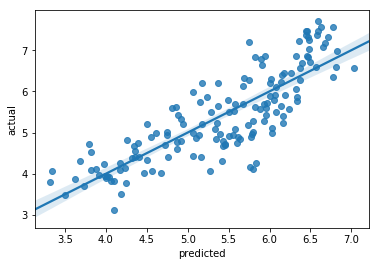

In [19]:
sns.regplot('predicted', 'actual', data=predictions)

### Looks pretty good?

Yeah, but we need a _score_ of some kind. A number (or set of numbers) that summarize how good the model is.

For regression problems, typically this is **mean-squared-error (MSE)**.

(Mathematically this can be translated into a pearson `r` or `r²` value if you prefer.)

#### One way to do this, by hand...

In [20]:
predictions['sq_error'] = (predictions['predicted'] - predictions['actual']) ** 2
predictions.head()

,predicted,actual,sq_error
country,,,
Afghanistan,3.999329,3.898032,0.010261
Albania,5.332008,5.092158,0.057528
Algeria,5.671868,5.685064,0.000174
Angola,5.063091,4.420299,0.413181
Argentina,6.258402,6.440702,0.033233


In [21]:
MSE = np.mean(predictions['sq_error'])
print(MSE)

0.3653226436822729


#### Another way: use handy sklearn libraries, like the [metrics](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics) library.

(Google or look at the docs to find them)

In [22]:
from sklearn import metrics

In [23]:
metrics.mean_squared_error(predictions['actual'], predictions['predicted'])

0.3653226436822729

### So we can predict happiness within about 1/3 of a point, ish.
Q: Any problem with this?

A: We are measuring our model's performance on the same data it used to fit. That is, our **training data** and our **testing data** are the same!

This is inherently dishonest. Imagine studying for a math test where you knew the test questions (and answers!) in advance. How can you be sure you really learned the concepts, and didn't just memorize the answers?

If you said "I have a model that can predict the stock market perfectly, proven by showing how it predicts the past stock market perfectly." Would anybody believe you? Or buy it?

**You need separate training and testing data**. That is, the testing data should be "out of sample."

## 5.2 Measure performance more honestly with _cross-validation_

Typically, you might use (say) 80% of your data for training and 20% for testing.

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777)

#### Note the extra argument, `random_state=777`
You don't normally need this.

Randomization code uses an internal random number generator, which sets its initial state when Python starts, based on god-knows-what (the current time, the CPU temperature, etc). Since this is a lesson and I want my results to be replicable, I'm specifying an exact state here. You should (hopefully) now get the same results as me.

### What did this do?

In [25]:
X_train.head()

,mortality_under5_per_1k,log_gdp_per_capita,gini_percent,education_expected,taxes_percent_gdp,co2_per_capita
country,,,,,,
Russia,10.1,4.372253,39.690000,14.68839,15.055675,12.647328
China,12.7,4.061625,37.012075,13.07282,10.636195,6.710302
Senegal,55.3,3.336475,40.310000,7.94567,19.182225,0.589493
South Africa,43.9,4.082985,65.020000,13.55794,26.496690,9.257216
Belarus,4.9,4.231840,26.460000,15.66023,15.140211,6.682510


In [26]:
X_test.head()

,mortality_under5_per_1k,log_gdp_per_capita,gini_percent,education_expected,taxes_percent_gdp,co2_per_capita
country,,,,,,
Laos,71.4,3.669069,36.22,10.57806,14.832002,0.184438
Belgium,4.4,4.608604,33.14,16.33158,24.857085,8.849398
Mozambique,87.2,3.029231,45.66,9.28123,20.790495,0.133514
Vietnam,23.8,3.709660,35.62,11.90000,16.780546,1.971889
Tajikistan,47.7,3.385903,30.77,11.24404,15.559569,0.356149


### Now let's fit our model on training data and measure performance on testing data

In [27]:
cv_model = LinearRegression()
cv_model.fit(X_train, y_train)

predictions = cv_model.predict(X_test)  # Note we're using X_test now!
actual = y_test
MSE_cv = metrics.mean_squared_error(actual, predictions)

print(f"Cross-validated MSE: {MSE_cv:.3f}")
print(f"Non-cross-validated MSE: {MSE:.3f}")

Cross-validated MSE: 0.515
Non-cross-validated MSE: 0.365


### Which model is better? Why?
A: The non-cv model, probably because it's overfitting. It was studying with the answer key! 

The CV model's performance is more honest, being evaluated on data it had never seen.

### It gets worse.
What happens if I run the EXACT SAME CODE, but with a slightly different random split?

In [28]:
# Change random_state from 777 to 55
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=55)

# Note: It's bad that I'm copy/pasting the nearly-exact-same code here.
# I should really pull all this out into a function, to adhere to
# the coding maxim of "Don't Repeat Yourself" (DRY)

cv_model = LinearRegression()
cv_model.fit(X_train, y_train)

predictions = cv_model.predict(X_test)  # Note we're using X_test now!
actual = y_test
MSE_cv = metrics.mean_squared_error(actual, predictions)

print(f"Cross-validated MSE: {MSE_cv:.3f}")
print(f"Non-cross-validated MSE: {MSE:.3f}")

Cross-validated MSE: 0.217
Non-cross-validated MSE: 0.365


### Whoa! The CV model is now *better*?!?

Q: What happened?

A: Our model performance can change a lot based on the random split!

* This is especially true for small datasets like this.
* What do we do?

## 5.3 K-fold cross-validation

The simple answer: do this random split/train/test thing a bunch of times!

In [29]:
# OK FINE I'LL MAKE A FUNCTION

def fit_once(X, y):
    # Don't set random_state -- we'll get a fresh split every time.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2)

    cv_model = LinearRegression()
    cv_model.fit(X_train, y_train)

    predictions = cv_model.predict(X_test)  # Note we're using X_test now!
    actual = y_test
    mse = metrics.mean_squared_error(actual, predictions)
    return mse

In [30]:
N_FOLDS = 1000

fold_results = []
for i in range(N_FOLDS):
    mse = fit_once(X, y)
    fold_results.append(mse)

## Advanced: this line does the same thing as the four lines above:
# fold_results = [fit_once(X, y) for i in range(N_FOLDS)]
## (Google "python list comprehensions" later at home).

overall_mean = np.mean(fold_results)
print("Overall mean:", overall_mean)

Overall mean: 0.40389616779494386


In  65% of random train-test splits, the cross-validated MSE is worse than the in-sample MSE.


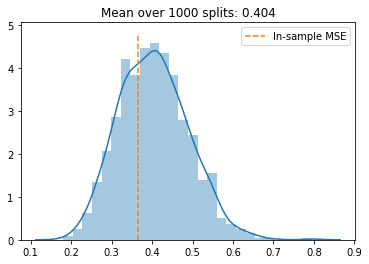

In [31]:
graph = sns.distplot(fold_results)
graph.set_title(f"Mean over {N_FOLDS} splits: {overall_mean:.3f}")

# Let's draw a line on the graph for our MSE when we trained and
# tested on the same data.
graph.plot([MSE, MSE], [0, graph.get_ylim()[1]], linestyle='--', label='In-sample MSE')
graph.legend()

print(f"In {(np.mean(fold_results > MSE) * 100): .0f}% of random train-test splits, the cross-validated MSE is worse than the in-sample MSE.")

### What's the lesson?
* **Cross-validation produces honest estimates of model performance**
* K-fold cross validation is more reliable, smoothing out lucky/unlucky train-test splits.

## 6. [As time allows] Model ~~twerking~~ tweaking

What happens if we add a new feature (say, [internet adoption](https://www.aquare.la/en/how-vortx-big-data-organises-the-world/))? Remove an old feature? Take the log of a feature? Multiply two features??

Slow down, one thing at a time.

Let's try removing GDP altogether. How much does this hurt our model?

In [32]:
without_gdp = df.drop(columns='log_gdp_per_capita')
without_gdp.head()  # Always check head() to be sure your data looks right

,happiness,mortality_under5_per_1k,gini_percent,education_expected,taxes_percent_gdp,co2_per_capita
country,,,,,,
Afghanistan,3.898032,97.3,27.820000,9.27439,7.471639,0.420933
Albania,5.092158,14.9,28.960000,11.82000,19.630699,1.607038
Algeria,5.685064,25.2,38.816667,13.96534,37.361849,3.224202
Angola,4.420299,167.4,42.660000,11.39000,18.836676,1.472216
Argentina,6.440702,13.3,43.570000,17.94733,14.483361,4.665869


### Yes, again I'm copy/pasting code below, which is bad.

Generally, I let myself be a little lazy in the early stages, but:
1. Before I publish my work, I always refactor to use clean functions.
2. Even as I'm doing my work, if I copy/paste something *more than once*, I take the time to make a proper function.


In [33]:
X = without_gdp.drop(columns='happiness')
y = without_gdp['happiness']

N_FOLDS = 1000

fold_results = []
for i in range(N_FOLDS):
    mse = fit_once(X, y)
    fold_results.append(mse)

mean_with_gdp = overall_mean
overall_mean = np.mean(fold_results)
print("Overall mean:", overall_mean)

Overall mean: 0.5180314708431838


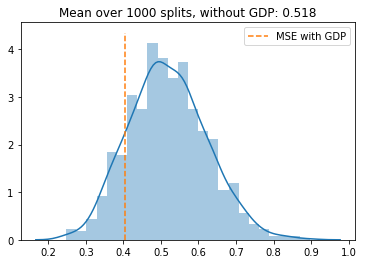

In [34]:
graph = sns.distplot(fold_results)
graph.set_title(f"Mean over {N_FOLDS} splits, without GDP: {overall_mean:.3f}")

graph.plot([mean_with_gdp, mean_with_gdp],
           [0, graph.get_ylim()[1]], linestyle='--', label='MSE with GDP')
graph.legend()

### This is "model comparison"
Clearly we can't remove GDP without a big performance hit. In this same fashion, we can try a lot of things to try to make the model better, simpler, or both.

### What if we drop everything *except* GDP and education?

In [35]:
# Shut up already about copy/pasting code

X = df[['log_gdp_per_capita', 'education_expected']]
y = df['happiness']

N_FOLDS = 1000

fold_results = []
for i in range(N_FOLDS):
    mse = fit_once(X, y)
    fold_results.append(mse)

overall_mean = np.mean(fold_results)
print("Overall mean:", overall_mean)

Overall mean: 0.38720511138560804


### Our model got simpler _and_ better! How?
A: Removing extraneous features helped prevent overfitting on our small dataset

## 7. [As time allows] Other algorithms

In [36]:
# Let's reset our X and y to use the full dataset
X = df.drop(columns='happiness')
y = df['happiness']

Remember this code? For fitting a Linear Regression model?

In [37]:
model = LinearRegression()  # Create a blank class instance
model.fit(X, y)  # fit!

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### Fitting other models is just as easy!

Here's a random forest (usually used for classification, not regression, but anyway...)

In [38]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X, y)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### Let's redo our fitting function to make it more general

In [39]:
def fit_one_forest(X, y, trees=10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2)
    # The number of trees in the forest is a "hyperparameter" --
    # it affects how the algorithm runs. We can also tweak this
    # number to find the best value.
    model = RandomForestRegressor(n_estimators=trees)
    model.fit(X_train, y_train)
    return metrics.mean_squared_error(y_test, model.predict(X_test))

In [40]:
N_FOLDS = 1000

rf_results = []
for i in range(N_FOLDS):
    mse = fit_one_forest(X, y)
    rf_results.append(mse)

In [41]:
overall_mean = np.mean(rf_results)
print("Overall mean:", overall_mean)

pd.Series(rf_results).describe()

Overall mean: 0.3121963347967775


count    1000.000000
mean        0.312196
std         0.081296
min         0.116253
25%         0.254563
50%         0.304466
75%         0.356773
max         0.630314
dtype: float64

Text(0.5,1,'Random Forest: mean over 1000 splits: 0.312')

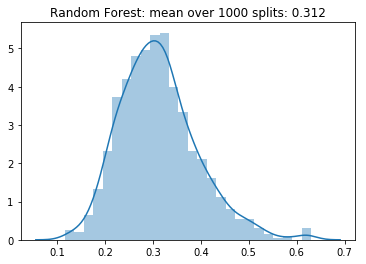

In [42]:
graph = sns.distplot(rf_results)
graph.set_title(f"Random Forest: mean over {N_FOLDS} splits: {overall_mean:.3f}")

### 8.2 Hyperparameters
#### Should we have used 10 trees? 100? ONE MILLION???
Let's search for the best value!

In [43]:
def fit_and_score(X, y, trees, n_folds):
    results = []
    for i in range(n_folds):
        results.append(fit_one_forest(X, y, trees=trees))
    return np.mean(results)

In [44]:
# Let's just do 100 folds because fitting forests
# with lots of trees can be sloooowww
N_FOLDS = 100
TREE_COUNTS = [1, 5, 10, 25, 100, 200]

results = []
for trees in TREE_COUNTS:
    score = fit_and_score(X, y, trees, N_FOLDS)
    results.append(score)
    print(trees, score)

1 0.5251746081588204
5 0.32339807843634605
10 0.3137937626878872
25 0.2963285547928383
100 0.2903772591572758
200 0.29277928695480676


In [45]:
trees_df = pd.DataFrame(zip(TREE_COUNTS, results), columns=['trees', 'MSE'])
trees_df.set_index('trees', inplace=True)
trees_df

,MSE
trees,
1,0.525175
5,0.323398
10,0.313794
25,0.296329
100,0.290377
200,0.292779


Text(0.5,1,'MSE as a function of the number of RF trees')

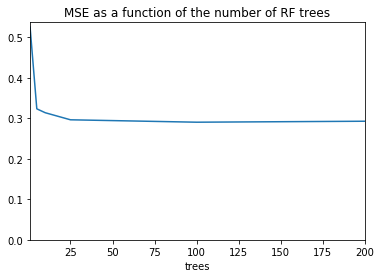

In [46]:
graph = trees_df['MSE'].plot()
graph.set_ylim(0, graph.get_ylim()[1])
graph.set_title('MSE as a function of the number of RF trees')

### It's beyond our scope to explain the innards of all machine learning models.
If ML is new to you, you can find lots of great resources online (I'll mention the [scikit-learn docs](https://scikit-learn.org/stable/documentation.html) for a third time now), or through the division of data sciences here at Cal.

## 8. [As time allows] Going pro: turn the honesty up to 11
### In all of this, _we are still cheating_. How?
A: We are doing this tweak-measure-tweak-measure thing using all the same data. In advertently we may be overfitting by beating the test set to death. We also used all the data (where we saw the strong correlations of gdp and education with happiness) to inform our choice of features, letting the test information "creep" into our training. Bad form!

### What to do? Take out a final, pristine, untouchable "holdout" set _before you even begin exploring your data_ (long before modelling)

We've already broken this rule and can't un-see what we've seen. We used information from the complete dataset to build our intuitions and our model.

If we could go back in time, we should do it like this:
1. Do basic cleaning only (reformat/rename columns, fix typos, etc)
1. Save a random (say) 20% of the rows to a separate, clean file, e.g. `data/holdout.csv`
1. Save the rest to a file for model building, e.g. `data/holdin.csv`
1. Go through exploring and model building (as in this file) with the `holdin` dataset only. Once you've decided on your final "best" model, and pinky-swear to not change anything, load in the holdout data and fit/predict/score your model on it. This score is guaranteed to be an unbiased estimate of your model's performance. You can use the variance of your prior cross-validation as a reasonable estimate of the standard error on this estimate.

## Whew, that was a lot! Thanks for sticking with it!